In [7]:
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import statsmodels.tsa.stattools as ts
import datetime
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
import numpy as np

yf.pdr_override()

In [28]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [2]:
TRAIN_TEST_RATIO = 0.2
yf.pdr_override()

In [3]:
covid_pharma_tickers = ['PFE', 'MRNA', 'JNJ', 'AZN', 'NVAX']
start = '2020-03-01'
end = datetime.datetime.now().date().strftime('%Y-%m-%d')
print(f"Period: {start} to {end}")

Period: 2020-03-01 to 2020-08-11


In [4]:
prices = pdr.get_data_yahoo(covid_pharma_tickers, start=start, end=end)['Adj Close']
prices.tail()

Symbols,PFE,MRNA,JNJ,AZN,NVAX
Date,,,,,
2020-08-04,38.389999,78.459999,147.220001,56.080002,157.169998
2020-08-05,38.450001,75.800003,148.399994,55.950001,173.490005
2020-08-06,38.270000,73.760002,147.550003,56.209999,167.500000
2020-08-07,38.450001,74.099998,148.600006,55.410000,170.289993
2020-08-10,38.389999,72.010002,148.029999,55.380001,178.509995


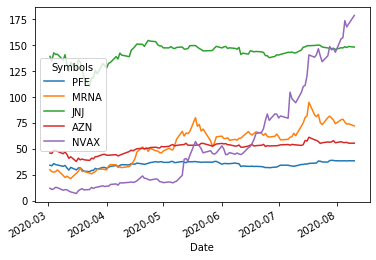

In [5]:
prices.plot()

In [10]:
data = prices['NVAX']

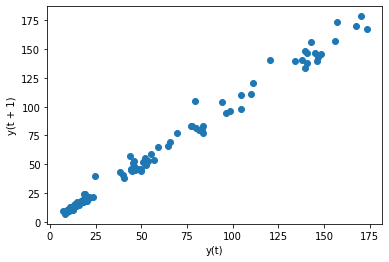

In [11]:
lag_plot(data)

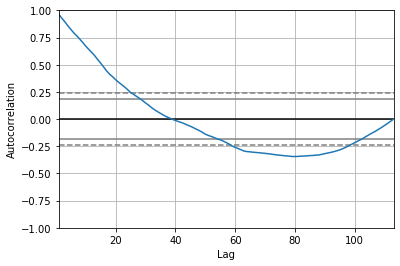

In [12]:
autocorrelation_plot(data)

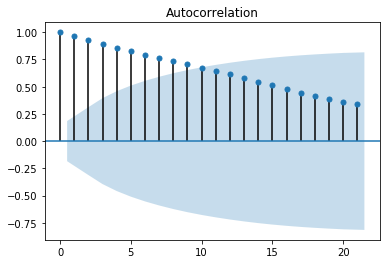

In [13]:
_ = plot_acf(data)

In [22]:
def prepare_sequence(series, n_steps):
    X, y = list(), list()
    for t, value in enumerate(series):
        if t < len(series) - n_steps:
            inp = series[t: t+n_steps]
            out = series[t+n_steps]
            X.append(inp)
            y.append(out)
    return np.array(X), np.array(y)

In [33]:
N_STEPS = 12
N_PREDICT = 1
N_FEATURES = 1 # dimension of the features vector, 1 in this case because it's just a scalar value

In [59]:
X, y = prepare_sequence(data, N_STEPS)

X_train, X_test = train_test_split(X, test_size=TRAIN_TEST_RATIO, shuffle=False)
y_train, y_test = train_test_split(y, test_size=TRAIN_TEST_RATIO, shuffle=False)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], N_FEATURES))
y_train = y_train.reshape((y_train.shape[0], N_PREDICT))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], N_FEATURES))
y_test = y_test.reshape((y_test.shape[0], N_PREDICT))
print(f"Training size: {len(X_train)}")
print(f"Testing size: {len(X_test)}")

Training size: 80
Testing size: 21


### Vanilla LSTM

In [43]:
def build_model(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [62]:
# usage
model = build_model(N_STEPS, N_PREDICT)
model.fit(X_train, y_train, epochs=1000, verbose=1)

Epoch 1/1000
3/3 [==============================] - 0s 4ms/step - loss: 4594.1758
Epoch 2/1000
3/3 [==============================] - 0s 4ms/step - loss: 3647.9336
Epoch 3/1000
3/3 [==============================] - 0s 4ms/step - loss: 2957.5503
Epoch 4/1000
3/3 [==============================] - 0s 5ms/step - loss: 2298.8179
Epoch 5/1000
3/3 [==============================] - 0s 4ms/step - loss: 1634.5469
Epoch 6/1000
3/3 [==============================] - 0s 5ms/step - loss: 976.6409
Epoch 7/1000
3/3 [==============================] - 0s 5ms/step - loss: 465.9854
Epoch 8/1000
3/3 [==============================] - 0s 5ms/step - loss: 186.8947
Epoch 9/1000
3/3 [==============================] - 0s 4ms/step - loss: 280.7775
Epoch 10/1000
3/3 [==============================] - 0s 4ms/step - loss: 270.9894
Epoch 11/1000
3/3 [==============================] - 0s 5ms/step - loss: 176.4854
Epoch 12/1000
3/3 [==============================] - 0s 5ms/step - loss: 130.4213
Epoch 13/1000
3/3 [=

Test RMSE: 18.914975542275684


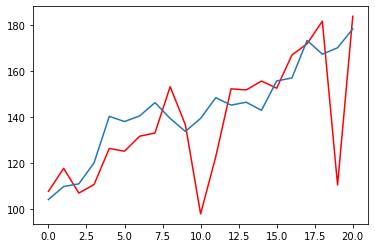

In [69]:
# test
predictions = model.predict(X_test)
plt.plot(predictions, color='r')
plt.plot(y_test)
rmse = np.sqrt(mean_squared_error(predictions, y_test))
print(f"Test RMSE: {rmse}")